In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model,load_model
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data generators

In [ ]:
def image_gen_w_aug(train_parent_directory, validation_parent_directory,test_parent_directory):
  train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,#rescale = 1./255,
                                   rotation_range=30,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True)#,
                                   #fill_mode='nearest')
                                   #validation_split=0.2) # val 20%

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input )#rescale = 1./255)

  validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #rescale = 1./255

  train_generator = train_datagen.flow_from_directory(
       train_parent_directory,
       target_size=(299, 299),
       batch_size=8,
       class_mode='categorical',
       #class_mode='sparse',  # ✅ CHANGED to sparse
      shuffle=True)
    #subset='training') # set as training data

  validation_generator = validation_datagen.flow_from_directory(
    validation_parent_directory, # same directory as training data
    target_size=(299, 299),
    batch_size=8,
    class_mode='categorical',
    #class_mode='sparse',  # ✅ CHANGED to sparse
    shuffle=False)
    #subset='validation') # set as validation data

  test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(299,299),
                                 batch_size = 8,
                                 class_mode = 'categorical',
                                 #class_mode='sparse',  # ✅ CHANGED to sparse
                                 shuffle=False)
  return train_generator, validation_generator, test_generator

In [ ]:
train_dir='/content/drive/MyDrive/Skin/Hakimi dataset/training'
val_dir='/content/drive/MyDrive/Skin/Hakimi dataset/validation'
test_dir='/content/drive/MyDrive/Skin/Hakimi dataset/testing'
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir,test_dir)

Found 416 images belonging to 4 classes.
Found 52 images belonging to 4 classes.
Found 52 images belonging to 4 classes.


In [ ]:
# 4. Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['Chickenpox', 'Hand Foot Mouth Disease', 'Heat Rash', 'Herpes Zoster']
Number of classes: 4


Hyperparameters

In [ ]:
num_classes = len(class_names)
lr=1e-4
batch_size=8


#Step 2: Build model with mixed5

In [ ]:
def build_consistent_model(input_shape=(299, 299, 3), num_classes=num_classes, lr=1e-4):
    # ✅ EXACTLY the same as your single split model
    pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model (same as single split)
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Use 'mixed5' layer EXACTLY like your single split
    last_layer = pre_trained_model.get_layer('mixed5')  #
    last_output = last_layer.output

    # Same custom top layers
    x = Flatten()(last_output)                        #
    x = Dense(512, activation='relu')(x)              #
    x = Dropout(0.2)(x)                               # E
    x = Dense(num_classes,activation='softmax')(x)

    model = Model(pre_trained_model.input, x)

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:

model = build_consistent_model(input_shape=(299, 299, 3), num_classes=num_classes)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 6. Check model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 118,780,644 (453.11 MB)

 Trainable params: 113,641,988 (433.51 MB)

 Non-trainable params: 5,138,656 (19.60 MB)

In [ ]:
steps_per_epoch = int(train_generator.samples // batch_size) #416/8=52
print(steps_per_epoch)

52


In [ ]:
validation_steps = int(validation_generator.samples // batch_size) #52/8 =6.5
print(validation_steps)

6


In [ ]:
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Skin/best_inceptionv3_weights_23Okt25.h5',
    monitor='val_accuracy',
    save_best_only=True, #saved the entire model (architecture + weights + optimizer state)
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    #mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[checkpoint, early_stop], #, early_stop,reduce_lr ],
      validation_steps=validation_steps)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3292 - loss: 9.1958
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to /content/drive/MyDrive/Skin/best_inceptionv3_weights_23Okt25.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.3300 - loss: 9.1261 - val_accuracy: 0.4167 - val_loss: 2.9151
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5945 - loss: 1.6194
Epoch 2: val_accuracy did not improve from 0.41667
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.5939 - loss: 1.6180 - val_accuracy: 0.4167 - val_loss: 1.5912
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6091 - loss: 1.3089
Epoch 3: val_accuracy improved from 0.41667 to 0.70833, saving model to /content/drive/MyDrive/Skin/best_inceptionv3_weights_23Okt25.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step - accuracy: 0.6092 - loss: 1.3064 - val_accuracy: 0.7083 - val_loss: 0.8533
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6441 - loss: 0.8430
Epoch 4: val_accuracy did not improve from 0.70833
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 577ms/step - accuracy: 0.6440 - loss: 0.8431 - val_accuracy: 0.7083 - val_loss: 0.9104
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7077 - loss: 0.7376
Epoch 5: val_accuracy did not improve from 0.70833
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.7076 - loss: 0.7388 - val_accuracy: 0.4792 - val_loss: 1.4915
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8133 - loss: 0.5479
Epoch 6: val_accuracy did not improve from 0.70833
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.8127 - loss: 0.5492 - val_accuracy: 0.6875 - val_loss: 1.0401
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7985 - loss: 0.5780
Epoch 7: val_accuracy did n

52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - accuracy: 0.8055 - loss: 0.5599 - val_accuracy: 0.7292 - val_loss: 0.8941
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8637 - loss: 0.3732
Epoch 11: val_accuracy did not improve from 0.72917
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 592ms/step - accuracy: 0.8634 - loss: 0.3740 - val_accuracy: 0.7083 - val_loss: 0.8256
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8610 - loss: 0.3666
Epoch 12: val_accuracy did not improve from 0.72917
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.8603 - loss: 0.3685 - val_accuracy: 0.7083 - val_loss: 0.9280
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8315 - loss: 0.4182
Epoch 13: val_accuracy did not improve from 0.72917
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8320 - loss: 0.4171 - val_accuracy: 0.6667 - val_loss: 0.9338
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8605 - loss: 0.3911
Epoch 14: val_accura

52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - accuracy: 0.8557 - loss: 0.3868 - val_accuracy: 0.7500 - val_loss: 0.9850
Epoch 17/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9026 - loss: 0.2828
Epoch 17: val_accuracy did not improve from 0.75000
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - accuracy: 0.9024 - loss: 0.2835 - val_accuracy: 0.6458 - val_loss: 1.3501
Epoch 18/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9289 - loss: 0.2058
Epoch 18: val_accuracy did not improve from 0.75000
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.9285 - loss: 0.2069 - val_accuracy: 0.6667 - val_loss: 0.9926
Epoch 19/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9402 - loss: 0.1698
Epoch 19: val_accuracy did not improve from 0.75000
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.9400 - loss: 0.1705 - val_accuracy: 0.7083 - val_loss: 1.0132
Epoch 20/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8842 - loss: 0.3571
Epoch 20: val_accura

In [ ]:
tf.keras.models.save_model(model,'/content/drive/MyDrive/Skin/my_inceptionskinmodel.hdf5')

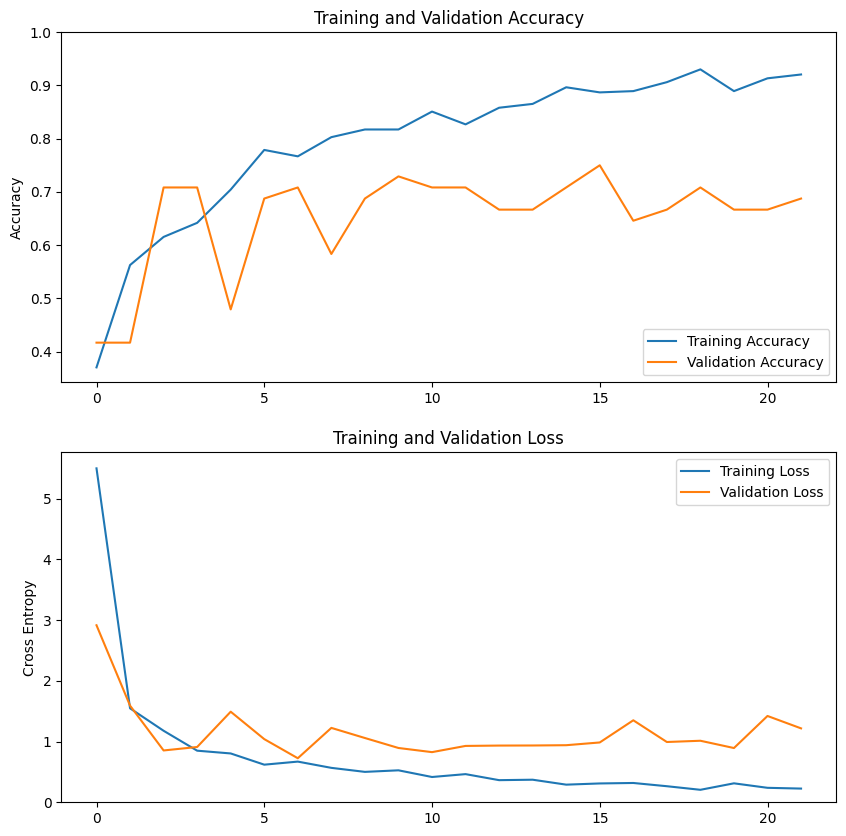

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
num_of_test_samples=test_generator.samples
print(num_of_test_samples)
print(batch_size)
Ytest_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
ytest_pred = np.argmax(Ytest_pred, axis=1)
y_true = test_generator.classes
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, ytest_pred))
print('Classification Report')

target_names = ['Chickenpox','HFMD',
    'Heat Rash','Herpes Zoster' ]
print(classification_report(y_true, ytest_pred, target_names=target_names))

52
8
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step
Confusion Matrix
[[12  0  1  0]
 [ 0 11  1  1]
 [ 2  0 11  0]
 [ 0  0  1 12]]
Classification Report
               precision    recall  f1-score   support

   Chickenpox       0.86      0.92      0.89        13
         HFMD       1.00      0.85      0.92        13
    Heat Rash       0.79      0.85      0.81        13
Herpes Zoster       0.92      0.92      0.92        13

     accuracy                           0.88        52
    macro avg       0.89      0.88      0.89        52
 weighted avg       0.89      0.88      0.89        52



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.8813 - loss: 0.3280
InceptionV3 Testing_accuracy from model evaluate: 0.8846153616905212
InceptionV3 Testing loss: 0.32516348361968994
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
Testing accuracy from metrics accuracy score InceptionV3:   0.885
Validation Confusion Matrix for InceptionV3
Confusion matrix, without normalization
InceptionV3
                         precision    recall  f1-score   support

             Chickenpox       0.86      0.92      0.89        13
Hand Foot Mouth Disease       1.00      0.85      0.92        13
              Heat Rash       0.79      0.85      0.81        13
          Herpes Zoster       0.92      0.92      0.92        13

               accuracy                           0.88        52
              macro avg       0.89      0.88      0.89        52
           weighted avg       0.89      0.88      0.89        52



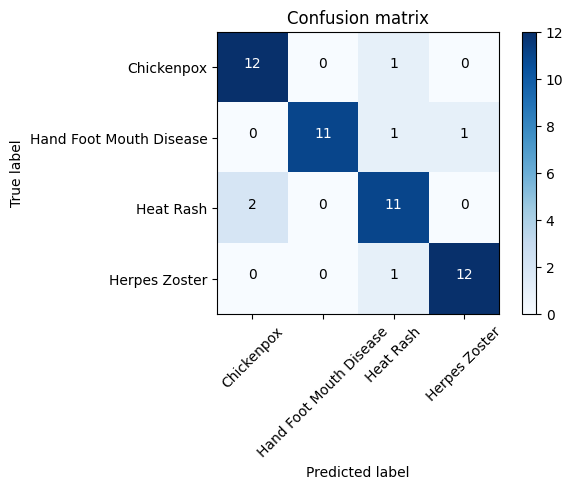

In [ ]:

model_name = "InceptionV3"
target_names = ['Chickenpox', 'Hand Foot Mouth Disease', 'Heat Rash', 'Herpes Zoster']
test_loss, test_acc = model.evaluate(test_generator)
print(f"{model_name} Testing_accuracy from model evaluate: {test_acc}")
print(f"{model_name} Testing loss: {test_loss}")
 #Predict on test data
predictions = model.predict(test_generator)
# Calculate accuracy
y_true = test_generator.classes
y_pred = predictions.argmax(axis=1) # this for categorical
#y_pred = (predictions > 0.5).astype(int)
accuracy = metrics.accuracy_score(y_true, y_pred)
print(f"Testing accuracy from metrics accuracy score {model_name}:   {accuracy:.3f}")
# Confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
print(f'Validation Confusion Matrix for {model_name}')
plot_confusion_matrix(cm, target_names)

# Classification report
print(f"{model_name}")
print(classification_report(y_true, y_pred, target_names=target_names))
#print(f"Done in {time() - t0:.3f}s")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


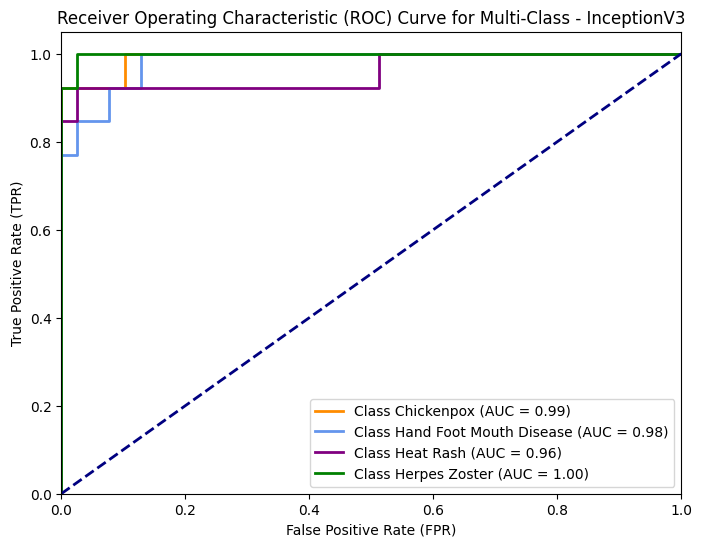

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
Ytest_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
#ytest_pred = np.argmax(Ytest_pred, axis=1)
def plot_roc_curve(y_pred_proba, y_true, class_labels, colors, model_name):
    # Mapping from original class labels to desired class names
    class_names = {
        0: 'Class Chickenpox',
        1: 'Class Hand Foot Mouth Disease',
        2: 'Class Heat Rash',
        3: 'Class Herpes Zoster'
    }

    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        original_label = class_labels[i]
        fpr[i], tpr[i], _ = roc_curve((y_true== original_label).astype(int), y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score((y_true == original_label).astype(int), y_pred_proba[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        original_label = class_labels[i]
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{class_names[original_label]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for Multi-Class - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Assuming you have the predicted probabilities from your model
# Replace this with your actual predicted probabilities
#y_scores = h5model.predict(X_test)

# Assuming you have true labels
# Replace this with your actual true labels
#y_true = y_test.argmax(axis=1)  # Convert one-hot encoding to class labels

# Assuming class labels
class_labels = [0, 1, 2,3]

# Colors for plotting
colors = ['darkorange', 'cornflowerblue', 'purple', 'green']

# Example usage
plot_roc_curve(Ytest_pred, y_true, class_labels, colors, model_name='InceptionV3')